### Analyze the Spread of Novel CoronaVirus 
#### Data Source: [Johns Hopkins University](https://docs.google.com/spreadsheets/d/1wQVypefm946ch4XDp37uZ-wartW4V7ILdg-qYiDXUHM/htmlview?sle=true)

#### How to [access](https://towardsdatascience.com/accessing-google-spreadsheet-data-using-python-90a5bc214fd2) 

In [1]:
import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import timedelta

In [2]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)
client = gspread.authorize(creds)

#### Load all sheets in the underlying file

In [3]:
##sheet = client.open('Learning Log').sheet1
sheet = client.open_by_url('https://docs.google.com/spreadsheets/d/1wQVypefm946ch4XDp37uZ-wartW4V7ILdg-qYiDXUHM/htmlview?sle=true')
worksheet_list = sheet.worksheets()

len(worksheet_list)

raw_df = pd.DataFrame()
for worksheet in worksheet_list:
    sub_data = worksheet.get_all_records()
    sub_table = pd.DataFrame(sub_data)
    sub_table['sheet_name'] = worksheet._properties['title']
    raw_df = pd.concat([raw_df, sub_table])

raw_df.head()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


,,Confirmed,Country,Country/Region,Date last updated,Deaths,Demised,Last Update,Province/State,"Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.",Recovered,Suspected,sheet_name
0,NaN,16678,NaN,Mainland China,NaN,479,NaN,2/4/20 23:43,Hubei,NaN,522,NaN,Feb04_10PM
1,NaN,895,NaN,Mainland China,NaN,0,NaN,2/5/20 1:33,Zhejiang,NaN,63,NaN,Feb04_10PM
2,NaN,870,NaN,Mainland China,NaN,0,NaN,2/5/20 2:03,Guangdong,NaN,32,NaN,Feb04_10PM
3,NaN,764,NaN,Mainland China,NaN,2,NaN,2/5/20 1:13,Henan,NaN,41,NaN,Feb04_10PM
4,NaN,661,NaN,Mainland China,NaN,0,NaN,2/5/20 1:43,Hunan,NaN,35,NaN,Feb04_10PM


In [48]:
# Merge duplicate columns with different names

main_df = raw_df

main_df.loc[main_df.Deaths.isna(),'Deaths'] =  main_df.loc[main_df.Deaths.isna(),'Demised']

main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country']
#main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country_Region']

#main_df.loc[main_df['Province/State'].isna(),'Province/State'] =  main_df.loc[main_df['Province/State'].isna(),'Province_State']

main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Date last updated']
#main_df.loc[main_df['Last Update (UTC)'].isna(),'Last Update (UTC)'] = main_df.loc[main_df['Last Update (UTC)'].isna(),'Last_Update']
#main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Last Update (UTC)']

main_df.loc[main_df['Province/State'].isna(), 'Province/State'] = main_df.loc[main_df['Province/State'].isna(), 'Country/Region']
main_df.loc[main_df['Province/State']=='', 'Province/State'] = main_df.loc[main_df['Province/State']=='', 'Country/Region']

main_df = main_df.loc[:, ~main_df.columns.isin(['Demised' , 'Country' , 'Country_Region','Province_State',
                                                'Date last updated', 'Last Update (UTC)', 'Last_Update','',
                                               'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'])]
main_df.sample(5)

,Confirmed,Country/Region,Deaths,Last Update,Province/State,Recovered,Suspected,sheet_name
25,31,Mainland China,0,2/3/2020 0:53,Jilin,1,NaN,Feb02_9PM
13,31,Mainland China,,1/25/2020 12:00 PM,Jiangsu,1,,Jan25_10pm
46,2,Australia,0,2/2/20 22:33,South Australia,0,NaN,Feb03_940pm
27,7,Mainland China,,1/27/2020 20:30,Ningxia,,NaN,Jan27_830pm
37,8,Malaysia,0,1/31/2020 8:15,Malaysia,0,NaN,Feb01_11pm


In [49]:
main_df['month'] = main_df.sheet_name.str.split('_').apply(lambda x: x[0][:3])
main_df['day'] = main_df.sheet_name.str.split('_').apply(lambda x: x[0][3:])

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# merge duplicate country names
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'^China','Mainland China')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United States','US')

main_df['Last Update'] = pd.to_datetime(main_df['Last Update'])
main_df['Last Update'] = main_df['Last Update'] - timedelta(hours=2) # to deal with cases reported too early on next day

#main_df['day'] = main_df['Last Update'].dt.day
#main_df['month'] = main_df['Last Update'].dt.month

main_df = main_df.fillna(0) # will take max value in the next step
main_df.Deaths.replace('',0, inplace=True)
main_df.Confirmed.replace('',0, inplace=True)
main_df.Suspected.replace('',0, inplace=True)
main_df.Recovered.replace('',0, inplace=True)

In [51]:
main_df

,Confirmed,Country/Region,Deaths,Last Update,Province/State,Recovered,Suspected,sheet_name,month,day
0,16678,Mainland China,479,2020-02-04 21:43:00,Hubei,522,0,Feb04_10PM,Feb,04
1,895,Mainland China,0,2020-02-04 23:33:00,Zhejiang,63,0,Feb04_10PM,Feb,04
2,870,Mainland China,0,2020-02-05 00:03:00,Guangdong,32,0,Feb04_10PM,Feb,04
3,764,Mainland China,2,2020-02-04 23:13:00,Henan,41,0,Feb04_10PM,Feb,04
4,661,Mainland China,0,2020-02-04 23:43:00,Hunan,35,0,Feb04_10PM,Feb,04
...,...,...,...,...,...,...,...,...,...,...
22,0,Mainland China,0,2020-01-20 22:00:00,Heilongjiang,0,1,Jan22_12am,Jan,22
23,1,Japan,0,2020-01-20 22:00:00,Japan,0,0,Jan22_12am,Jan,22
24,2,Thailand,0,2020-01-20 22:00:00,Thailand,0,0,Jan22_12am,Jan,22
25,1,South Korea,0,2020-01-20 22:00:00,South Korea,0,0,Jan22_12am,Jan,22


In [52]:
clean_df =main_df.groupby(['Country/Region','Province/State','month','day']).agg({'Last Update':'max',
                                                                  'Confirmed':'max',
                                                                  'Suspected':'max',
                                                                  'Recovered':'max',
                                                                  'Deaths':'max'}).reset_index()

clean_df['period'] = pd.to_datetime('2020-' + clean_df.month.astype(str) + '-' + clean_df.day.astype(str))
clean_df = clean_df.sort_values(['Country/Region','Province/State','period'])

#### Some baisc checks

2020-01-22 10:00:00    38
2020-01-23 10:00:00    46
2020-01-24 10:00:00    40
2020-01-24 14:00:00     1
2020-01-25 10:00:00    42
                       ..
2020-02-04 23:53:00     1
2020-02-05 00:03:00     2
2020-02-05 00:33:00     1
2020-02-05 00:43:00     2
2020-02-05 00:53:00     2
Name: Last Update, Length: 120, dtype: int64

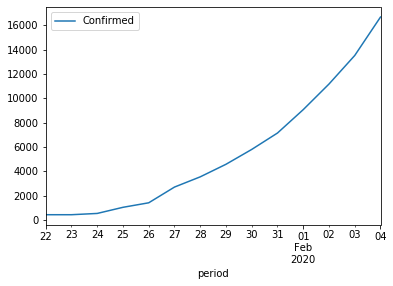

In [53]:
clean_df[clean_df['Province/State'] =='Hubei'].plot.line(x='period', y='Confirmed')

clean_df['Last Update'].value_counts().sort_index()

#### Some Analysis on spread and recovery

##### Growth rate of confirmed cases

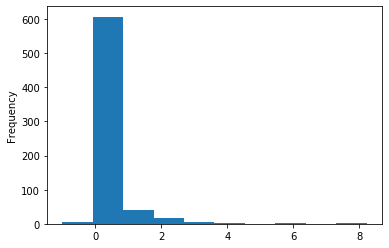

In [54]:
clean_df['Confirmed_lag'] = clean_df.groupby(['Province/State']).Confirmed.shift(1)

clean_df['growth number daily'] =  clean_df.Confirmed - clean_df.Confirmed_lag

clean_df['growth rate daily'] = clean_df.Confirmed / clean_df.Confirmed_lag - 1

clean_df[clean_df.Confirmed_lag > 0]['growth rate daily'].plot.hist()

In [55]:
clean_df['growth rate daily'].describe()

count    692.000000
mean            inf
std             NaN
min       -1.000000
25%        0.000000
50%        0.132593
75%        0.394099
max             inf
Name: growth rate daily, dtype: float64

In [56]:
# focus on cases where base is above 8
heavy_affect_df = clean_df[clean_df['Confirmed_lag'] >= 8]
heavy_affect_df.describe()

,Confirmed,Suspected,Recovered,Deaths,Confirmed_lag,growth number daily,growth rate daily
count,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000
mean,331.351499,1.217984,8.907357,7.190736,267.226158,64.125341,0.305089
std,1452.615922,8.643606,41.129970,45.441208,1174.097829,284.545272,0.558593
min,0.000000,0.000000,0.000000,0.000000,8.000000,-18.000000,-1.000000
25%,22.500000,0.000000,0.000000,0.000000,18.000000,3.000000,0.088523
50%,64.000000,0.000000,1.000000,0.000000,48.000000,10.000000,0.200000
75%,170.500000,0.000000,4.000000,0.000000,143.500000,29.000000,0.355991
max,16678.000000,117.000000,522.000000,479.000000,13522.000000,3156.000000,8.222222


In [57]:
heavy_affect_df['day count'] = heavy_affect_df.groupby('Province/State')['period'].rank()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
growth_df = heavy_affect_df.pivot_table(values = 'growth rate daily', index = 'day count', columns='Province/State').reset_index()
growth_df

Province/State,day count,Anhui,Beijing,Chongqing,Fujian,Gansu,Germany,Guangdong,Guangxi,Guizhou,...,Sichuan,Singapore,South Korea,Taiwan,Thailand,Tianjin,Vietnam,Xinjiang,Yunnan,Zhejiang
0,1.0,0.666667,0.571429,2.000000,0.800000,0.357143,0.25,0.230769,0.434783,0.000000,...,0.875000,0.000000,0.363636,0.000000,0.000000,0.625000,0.0,0.076923,0.727273,1.700000
1,2.0,3.000000,0.636364,1.777778,0.944444,0.263158,0.20,0.656250,0.393939,0.333333,...,1.933333,0.600000,0.000000,0.125000,0.750000,0.076923,NaN,0.214286,0.368421,0.592593
2,3.0,0.166667,0.416667,0.466667,0.685714,0.083333,0.00,0.849057,0.108696,0.250000,...,0.568182,0.125000,0.000000,0.111111,0.000000,0.642857,NaN,0.000000,0.692308,1.418605
3,4.0,0.514286,0.333333,0.200000,0.389831,0.115385,NaN,0.489796,0.137255,0.933333,...,0.304348,0.000000,0.066667,0.000000,0.000000,0.086957,NaN,0.235294,0.250000,0.230769
4,5.0,0.433962,0.176471,0.113636,0.231707,0.206897,NaN,0.034247,0.344828,0.310345,...,0.200000,0.000000,NaN,0.000000,0.357143,0.080000,NaN,0.142857,0.381818,0.351562
5,6.0,0.315789,0.137500,0.122449,0.000000,0.142857,NaN,0.596026,0.115385,0.210526,...,0.314815,0.333333,NaN,0.000000,0.000000,0.185185,NaN,0.208333,0.092105,0.710983
6,7.0,0.185000,0.219780,0.248485,0.188119,0.275000,NaN,0.290456,0.011494,0.217391,...,0.246479,NaN,NaN,0.100000,0.000000,0.000000,NaN,0.103448,0.120482,0.445946
7,8.0,0.000000,0.090090,0.155340,0.325000,0.078431,NaN,0.263666,0.261364,0.142857,...,0.000000,NaN,NaN,NaN,0.000000,0.406250,NaN,NaN,0.129032,0.254673
8,9.0,0.434599,0.148760,0.100840,0.000000,0.036364,NaN,0.109415,0.144144,NaN,...,0.305085,NaN,NaN,NaN,0.315789,0.066667,NaN,NaN,0.114286,0.001862
9,10.0,0.200000,0.316547,0.145038,0.125786,NaN,NaN,0.385321,0.094488,NaN,...,0.099567,NaN,NaN,NaN,NaN,0.250000,NaN,NaN,0.042735,0.228625


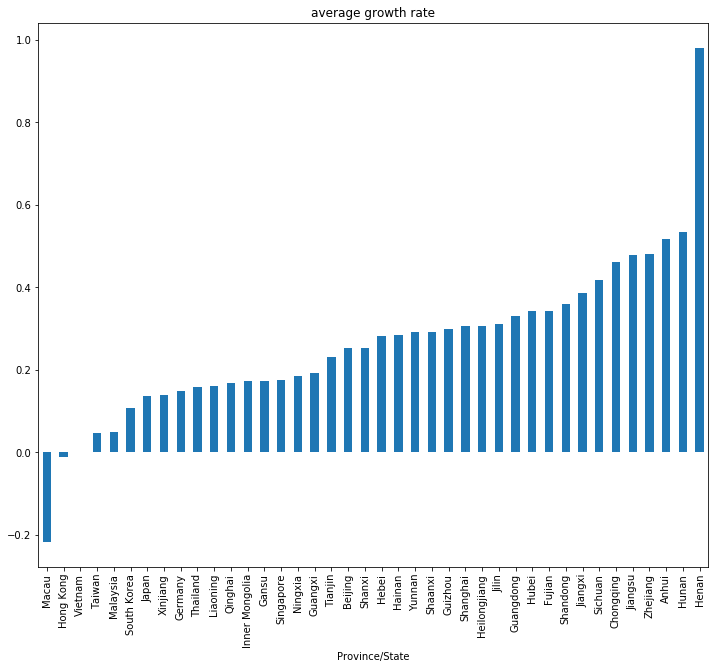

In [59]:
# arithmatic mean of growth rate
growth_df.set_index('day count').mean().sort_values().plot.bar(figsize=(12,10),
                                                              title='average growth rate')

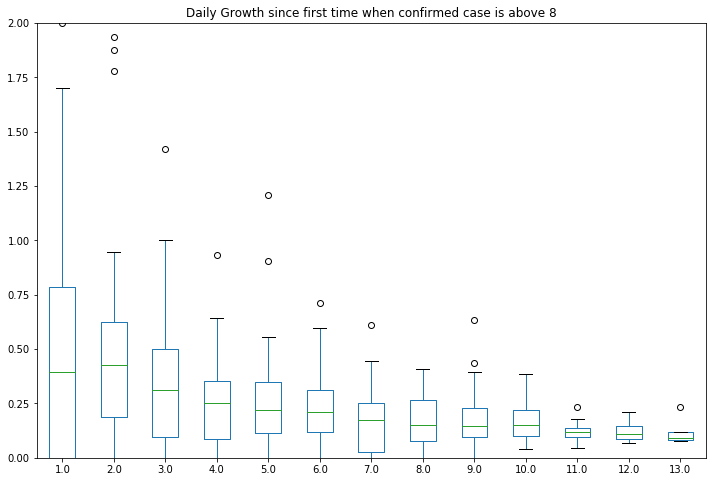

In [60]:
growth_df.set_index('day count').transpose().plot.box(figsize =(12, 8), 
                                         title ='Daily Growth since first time when confirmed case is above 8',
                                         ylim =(0, 2))

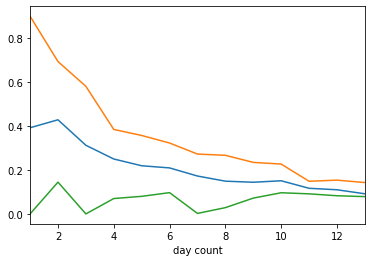

In [61]:
# deceleration? caveat: ommision bias

growth_df.set_index('day count').median(axis =1).plot()
growth_df.set_index('day count').quantile(q=0.8, axis =1).plot()
growth_df.set_index('day count').quantile(q=0.2, axis =1).plot()

In [62]:
# cumulative growth rate from base of the first time there is more than 8 "confirmed case"
earliest_df = heavy_affect_df. \
            groupby(['Province/State']). \
            agg({'Confirmed':'min'}).reset_index().rename(columns ={'Confirmed': 'base'})

earliest_df.sort_values(by='base',ascending=False).head()

,Province/State,base
14,Hubei,444
12,Henan,83
27,Shandong,39
19,Jiangxi,36
7,Guangxi,33


In [63]:
heavy_affect_df = pd.merge(heavy_affect_df, earliest_df, how = 'left', left_on = 'Province/State', right_on = 'Province/State')
heavy_affect_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,day count,base
0,Germany,Germany,Feb,02,2020-02-02 16:03:00,10,0,0,0,2020-02-02,8.0,2.0,0.250000,1.0,10
1,Germany,Germany,Feb,03,2020-02-03 18:53:00,12,0,0,0,2020-02-03,10.0,2.0,0.200000,2.0,10
2,Germany,Germany,Feb,04,2020-02-03 18:53:00,12,0,0,0,2020-02-04,12.0,0.0,0.000000,3.0,10
3,Hong Kong,Hong Kong,Jan,27,2020-01-27 18:30:00,8,0,0,0,2020-01-27,8.0,0.0,0.000000,2.0,0
4,Hong Kong,Hong Kong,Jan,28,2020-01-28 21:00:00,8,0,0,0,2020-01-28,8.0,0.0,0.000000,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,Thailand,Thailand,Feb,01,2020-02-01 08:00:00,19,0,7,0,2020-02-01,19.0,0.0,0.000000,6.0,8
363,Thailand,Thailand,Feb,02,2020-01-31 08:37:00,19,0,5,0,2020-02-02,19.0,0.0,0.000000,7.0,8
364,Thailand,Thailand,Feb,03,2020-01-31 08:37:00,19,0,5,0,2020-02-03,19.0,0.0,0.000000,8.0,8
365,Thailand,Thailand,Feb,04,2020-02-04 13:33:00,25,0,5,0,2020-02-04,19.0,6.0,0.315789,9.0,8


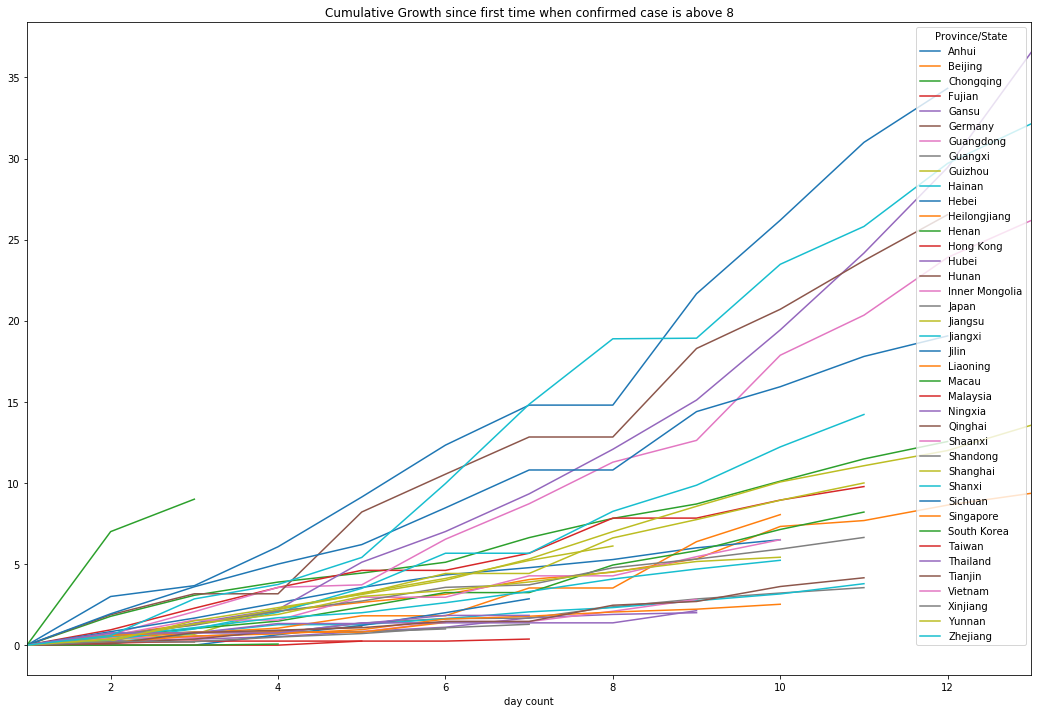

In [64]:
heavy_affect_df['cumulative growth'] = heavy_affect_df['Confirmed']/ heavy_affect_df['base'] - 1
cmlt_growth_df = heavy_affect_df.pivot_table(columns ='Province/State', index= 'day count', values='cumulative growth')
cmlt_growth_df.plot.line(figsize =(18, 12), 
                                         title ='Cumulative Growth since first time when confirmed case is above 8')

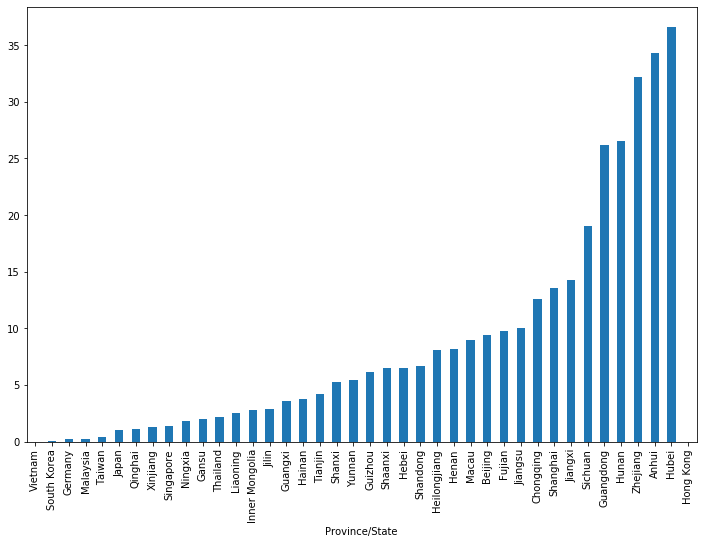

In [65]:
cmlt_growth_df.max().sort_values().plot.bar(figsize =(12,8))

In [66]:
cmlt_growth_df.max().sort_values().index

Index(['Vietnam', 'South Korea', 'Germany', 'Malaysia', 'Taiwan', 'Japan',
       'Qinghai', 'Xinjiang', 'Singapore', 'Ningxia', 'Gansu', 'Thailand',
       'Liaoning', 'Inner Mongolia', 'Jilin', 'Guangxi', 'Hainan', 'Tianjin',
       'Shanxi', 'Yunnan', 'Guizhou', 'Shaanxi', 'Hebei', 'Shandong',
       'Heilongjiang', 'Henan', 'Macau', 'Beijing', 'Fujian', 'Jiangsu',
       'Chongqing', 'Shanghai', 'Jiangxi', 'Sichuan', 'Guangdong', 'Hunan',
       'Zhejiang', 'Anhui', 'Hubei', 'Hong Kong'],
      dtype='object', name='Province/State')

In [67]:
# the following provinces/states have the highest cumulative growth
cmlt_growth_df[['Jiangxi', 'Chongqing',
       'Beijing', 'Sichuan', 'Shanghai', 'Hunan', 'Hubei', 'Guangdong',
       'Zhejiang', 'Anhui']]

Province/State,Jiangxi,Chongqing,Beijing,Sichuan,Shanghai,Hunan,Hubei,Guangdong,Zhejiang,Anhui
day count,,,,,,,,,,
1.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000
2.0,0.333333,1.777778,0.636364,1.933333,0.2500,1.875000,0.236486,0.65625,0.592593,3.000000
3.0,1.000000,3.074074,1.318182,3.600000,1.5000,3.166667,1.369369,2.06250,2.851852,3.666667
4.0,2.027778,3.888889,2.090909,5.000000,2.3125,3.166667,2.204955,3.56250,3.740741,6.066667
5.0,3.500000,4.444444,2.636364,6.200000,3.1250,8.208333,5.112613,3.71875,5.407407,9.133333
6.0,5.666667,5.111111,3.136364,8.466667,4.0000,10.541667,7.004505,6.53125,9.962963,12.333333
7.0,5.666667,6.629630,4.045455,10.800000,5.3125,12.833333,9.328829,8.71875,14.851852,14.800000
8.0,8.250000,7.814815,4.500000,10.800000,7.0000,12.833333,12.076577,11.28125,18.888889,14.800000
9.0,9.861111,8.703704,5.318182,14.400000,8.5625,18.291667,15.110360,12.62500,18.925926,21.666667


In [68]:
clean_df[clean_df['Province/State'] =='Hubei']

,Country/Region,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily
321,Mainland China,Hubei,Jan,22,2020-01-22 10:00:00,444,11,0,0,2020-01-22,NaN,NaN,NaN
322,Mainland China,Hubei,Jan,23,2020-01-23 10:00:00,444,0,28,17,2020-01-23,444.0,0.0,0.000000
323,Mainland China,Hubei,Jan,24,2020-01-24 10:00:00,549,0,31,24,2020-01-24,444.0,105.0,0.236486
324,Mainland China,Hubei,Jan,25,2020-01-25 20:00:00,1052,0,42,52,2020-01-25,549.0,503.0,0.916211
325,Mainland China,Hubei,Jan,26,2020-01-26 21:00:00,1423,0,44,76,2020-01-26,1052.0,371.0,0.352662
326,Mainland China,Hubei,Jan,27,2020-01-27 18:30:00,2714,0,47,100,2020-01-27,1423.0,1291.0,0.907238
327,Mainland China,Hubei,Jan,28,2020-01-28 21:00:00,3554,0,80,125,2020-01-28,2714.0,840.0,0.309506
328,Mainland China,Hubei,Jan,29,2020-01-29 19:00:00,4586,0,90,162,2020-01-29,3554.0,1032.0,0.290377
329,Mainland China,Hubei,Jan,30,2020-01-30 19:30:00,5806,0,116,204,2020-01-30,4586.0,1220.0,0.266027
330,Mainland China,Hubei,Jan,31,2020-01-31 17:00:00,7153,0,169,249,2020-01-31,5806.0,1347.0,0.232001


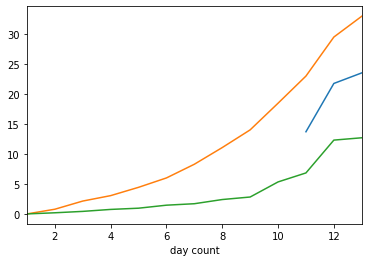

In [69]:
# deceleration? (caveat: ommited variable)
cmlt_growth_df.mean(axis=1).plot()
cmlt_growth_df.quantile(q=0.8,axis=1).plot()
cmlt_growth_df.quantile(q=0.2,axis=1).plot()

##### Recover rate using the latest data available

In [70]:
clean_df['recover rate'] = clean_df.Recovered / clean_df.Confirmed
latest_df = clean_df.groupby(['Province/State']).agg({'Last Update': 'max'}).reset_index()
latest_df

,Province/State,Last Update
0,Anhui,2020-02-04 23:13:00
1,Arizona,2020-02-01 08:00:00
2,Australia,2020-01-27 07:00:00
3,Bavaria,2020-02-01 08:00:00
4,Beijing,2020-02-04 06:33:00
...,...,...
77,Vietnam,2020-02-03 19:43:00
78,Washington,2020-02-01 08:00:00
79,Xinjiang,2020-02-05 00:03:00
80,Yunnan,2020-02-04 21:23:00


In [71]:
latest_df = pd.merge(clean_df, latest_df, how = 'right', left_on = ['Province/State', 'Last Update'], right_on = ['Province/State', 'Last Update'])
latest_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,recover rate
0,Australia,Australia,Jan,27,2020-01-27 07:00:00,5,0,0,0,2020-01-27,4.0,1.0,0.250000,0.000
1,Australia,New South Wales,Feb,01,2020-02-01 16:12:00,4,0,2,0,2020-02-01,4.0,0.0,0.000000,0.500
2,Australia,New South Wales,Feb,02,2020-02-01 16:12:00,4,0,2,0,2020-02-02,4.0,0.0,0.000000,0.500
3,Australia,New South Wales,Feb,03,2020-02-01 16:12:00,4,0,2,0,2020-02-03,4.0,0.0,0.000000,0.500
4,Australia,New South Wales,Feb,04,2020-02-01 16:12:00,4,0,2,0,2020-02-04,4.0,0.0,0.000000,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,United Arab Emirates,United Arab Emirates,Feb,02,2020-02-02 03:43:00,5,0,0,0,2020-02-02,4.0,1.0,0.250000,0.000
126,United Arab Emirates,United Arab Emirates,Feb,03,2020-02-02 03:43:00,5,0,0,0,2020-02-03,5.0,0.0,0.000000,0.000
127,United Arab Emirates,United Arab Emirates,Feb,04,2020-02-02 03:43:00,5,0,0,0,2020-02-04,5.0,0.0,0.000000,0.000
128,Vietnam,Vietnam,Feb,03,2020-02-03 19:43:00,8,0,1,0,2020-02-03,6.0,2.0,0.333333,0.125


Percentage over total confirmed cases: 3.68%


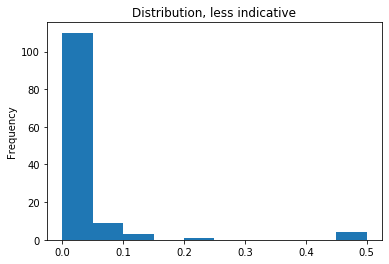

In [72]:
latest_df['recover rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Percentage over total confirmed cases: {0:.2%}'.format(latest_df.Recovered.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

#### Time-series Analysis on Growth Rate

In [73]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf

In [74]:
# focus on countries outside of China
outside_df = main_df[main_df['Country/Region']!= 'Mainland China']

In [75]:
outside_df[outside_df.day==3]['Province/State'].value_counts()

Series([], Name: Province/State, dtype: int64)

In [76]:
outside_df.groupby(['Province/State','month','day']). \
    agg({'Confirmed':'max','Recovered':'max','Suspected':'max','Deaths':'max'}).reset_index(). \
    groupby(['month','day']). \
    agg({'Confirmed':'sum','Recovered':'sum','Suspected':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

,month,day,Confirmed,Recovered,Suspected,Deaths,Province/State
0,Feb,01,189,12,0,1,41
1,Feb,02,181,9,0,1,36
2,Feb,03,191,9,0,1,39
3,Feb,04,213,9,0,2,39
4,Jan,22,6,0,0,0,4
5,Jan,23,14,0,77,0,15
6,Jan,24,25,0,36,0,11
7,Jan,25,40,0,244,0,14
8,Jan,26,57,3,244,0,17
9,Jan,27,70,3,0,0,23


In [77]:
china_df = main_df[main_df['Country/Region']=='Mainland China']

china_df.groupby(['Province/State','month','day']). \
    agg({'Confirmed':'max','Recovered':'max','Suspected':'max','Deaths':'max'}).reset_index(). \
    groupby(['month','day']). \
    agg({'Confirmed':'sum','Recovered':'sum','Suspected':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

,month,day,Confirmed,Recovered,Suspected,Deaths,Province/State
0,Feb,01,14375,331,0,304,31
1,Feb,02,17114,478,0,361,31
2,Feb,03,20400,635,0,425,31
3,Feb,04,24290,891,0,490,31
4,Jan,22,549,0,171,0,34
5,Jan,23,639,30,67,18,31
6,Jan,24,916,36,145,26,30
7,Jan,25,1979,49,163,57,30
8,Jan,26,2737,51,139,80,30
9,Jan,27,4409,60,0,108,30


In [78]:
# auto-correlation
[(x, acf(growth_df[x].dropna())) for x in growth_df.columns.to_list()]

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:578: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


[('day count',
  array([ 1.        ,  0.76923077,  0.54395604,  0.32967033,  0.13186813,
         -0.04395604, -0.19230769, -0.30769231, -0.38461538, -0.41758242,
         -0.4010989 , -0.32967033, -0.1978022 ])),
 ('Anhui',
  array([ 1.00000000e+00,  1.05854319e-02,  6.32947387e-02,  3.35221343e-02,
          3.07490095e-04, -6.19313818e-02, -1.67250967e-01, -1.89979456e-02,
         -9.51639382e-02, -1.04882034e-01, -1.50796842e-01, -8.68668551e-03])),
 ('Beijing',
  array([ 1.        ,  0.59698189,  0.2848067 ,  0.07843284, -0.08714083,
         -0.07260709, -0.10609962, -0.15205663, -0.09265891, -0.22133212,
         -0.34205517, -0.25785627, -0.12841478])),
 ('Chongqing',
  array([ 1.        ,  0.56389225,  0.06826787, -0.05386551, -0.09597357,
         -0.08043898, -0.08051815, -0.14485776, -0.17403625, -0.18577455,
         -0.2017961 , -0.11489925])),
 ('Fujian',
  array([ 1.        ,  0.67148097,  0.27866318, -0.0114295 , -0.14692501,
         -0.14769849, -0.16768304, -0.2797

In [35]:
# unable to run VAR due to missing values (synthetic control?)
model = AutoReg(growth_df['Sichuan'].dropna(), lags=1)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                Sichuan   No. Observations:                   12
Model:                     AutoReg(1)   Log Likelihood                  -8.473
Method:               Conditional MLE   S.D. of innovations              0.523
Date:                Wed, 05 Feb 2020   AIC                             -0.752
Time:                        23:39:13   BIC                             -0.643
Sample:                             1   HQIC                            -0.820
                                   12                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3779      0.176      2.144      0.032       0.032       0.723
Sichuan.L1     0.1532      0.237      0.648      0.517      -0.310       0.617
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            6.5254           +0.0000j            6.5254            0.0000
-----------------------------------------------------------------------------
"""

### ***Retired-*** 
#### Alternative method choose worksheet before merging (read from Excel manually downloaded)

In [36]:
file_path = 'Novel Coronavirus (2019-nCoV) Cases, provided by JHU CSSE.xlsx'
# raw_df = pd.concat(pd.read_excel(file_path, sheet_name= None), ignore_index = True, sort=True)

xl = pd.ExcelFile(file_path)
xl.sheet_names

['Feb02_9PM',
 'Feb02_745pm',
 'Feb02_5am',
 'Feb01_11pm',
 'Feb01_6pm',
 'Feb01_10am',
 'Jan31_7pm',
 'Jan31_2pm',
 'Jan30_930pm',
 'Jan30_11am',
 'Jan29_9pm',
 'Jan29_230pm',
 'Jan29_130pm',
 'Jan28_11pm',
 'Jan28_6pm',
 'Jan28_1pm',
 'Jan27_830pm',
 'Jan27_7pm',
 'Jan27_9am',
 'Jan26_11pm',
 'Jan26_11am',
 'Jan25_10pm',
 'Jan25_12pm',
 'Jan25_12am',
 'Jan24_12pm',
 'Jan24_12am',
 'Jan23_12pm',
 'Jan22_12pm',
 'Jan22_12am']

In [37]:
# use the latest time for each date
split_name_df = pd.DataFrame(data = list(map(lambda x: x.split('_'), xl.sheet_names)), columns =['date','hour'])
split_name_df

,date,hour
0,Feb02,9PM
1,Feb02,745pm
2,Feb02,5am
3,Feb01,11pm
4,Feb01,6pm
5,Feb01,10am
6,Jan31,7pm
7,Jan31,2pm
8,Jan30,930pm
9,Jan30,11am


In [38]:
# extract time components
split_name_df['suffix'] = split_name_df.hour.apply(lambda x: x[-2:])

split_name_df['hour_digit'] = split_name_df.hour.str.extract(r'(?P<hour>[\d]+)')

split_name_df['date_digit'] = split_name_df.date.str.extract('([\d]+)').astype(int)

In [39]:
# deal with special case of 12am and half-hour

split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] = split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] - 1

split_name_df['hour_digit'] = split_name_df.hour_digit.str.replace('30','').astype(int)

split_name_df.loc[split_name_df.hour == '12am', 'hour_digit'] = 24

split_name_df.loc[split_name_df.hour == '12am', 'suffix'] = 'pm'

In [40]:
# filter for the last file for each day

filter_name_df = split_name_df[split_name_df.suffix == 'pm']

filter_name_df = filter_name_df.groupby('date_digit').agg({'hour_digit':'max','suffix': 'max'}).reset_index()

filter_name_df

,date_digit,hour_digit,suffix
0,1,11,pm
1,2,745,pm
2,21,24,pm
3,22,12,pm
4,23,24,pm
5,24,24,pm
6,25,12,pm
7,26,11,pm
8,27,8,pm
9,28,11,pm


In [41]:
filter_name_df = pd.merge(split_name_df,filter_name_df, how = 'right', 
         left_on = ['date_digit', 'hour_digit','suffix'], right_on = ['date_digit','hour_digit','suffix'])

filter_name = (filter_name_df.date + '_' + filter_name_df.hour).to_list()
filter_name

['Feb02_745pm',
 'Feb01_11pm',
 'Jan31_7pm',
 'Jan30_930pm',
 'Jan29_9pm',
 'Jan28_11pm',
 'Jan27_830pm',
 'Jan26_11pm',
 'Jan25_12pm',
 'Jan25_12am',
 'Jan24_12am',
 'Jan22_12pm',
 'Jan22_12am']

In [42]:
main_2_df = pd.concat(pd.read_excel(file_path, sheet_name= filter_name), ignore_index = True)
main_2_df['Last Update'].value_counts()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


2020-01-31 19:00:00    63
2020-01-30 21:30:00    59
2020-01-29 21:00:00    56
2020-01-27 20:30:00    52
2020-01-28 23:00:00    51
2020-01-26 23:00:00    47
2020-01-25 12:00:00    44
2020-01-25 00:00:00    44
2020-01-22 12:00:00    38
2020-01-24 00:00:00    38
2020-01-28 18:00:00     1
Name: Last Update, dtype: int64

In [43]:
# def read_excel_sheets(xls_path):
#     """Read all sheets of an Excel workbook and return a single DataFrame"""
#     print(f'Loading {xls_path} into pandas')
#     xl = pd.ExcelFile(xls_path)
#     df = pd.DataFrame()
#     columns = None
#     for idx, name in enumerate(xl.sheet_names):
#         print(f'Reading sheet #{idx}: {name}')
#         sheet = xl.parse(name)
#         if idx == 0:
#             # Save column names from the first sheet to match for append
#             columns = sheet.columns
#         sheet.columns = columns
#         # Assume index of existing data frame when appended
#         df = df.append(sheet, ignore_index=True)
#     return df

# read_excel_sheets(file_name)